In [216]:
from pickle import load
import pandas as pd
import numpy as np
from mplsoccer import Pitch, VerticalPitch
from statsbombpy import sb
import matplotlib.pyplot as plt
from math import dist

from sklearn.linear_model import LogisticRegression

In [179]:
cross_prob = load(open("models/cross_model.pkl",'rb'))
xG = load(open("models/xG_historical_probs.pkl",'rb'))

In [213]:
cols = ['teammate', 'actor', 'keeper', 'location_x', 'id',
        'player', 'position', 'team', 'type', 'timestamp', 
        'pass_end_location', 'pass_outcome', 'pass_cross', 
        'interception_outcome', 'pass_aerial_won', 'visible_area']

events = sb.events(match_id=3788763)
match_frames = sb.frames(match_id=3788763, fmt='dataframe')

# join the events to the frames 
df = pd.merge(match_frames, events, left_on='id', right_on='id', how='left')

# take relevant rows 
df = df[cols]

# filter for crosses only
cross_df = df[df['pass_cross'] == True]


In [214]:
cross_df.head()

,teammate,actor,keeper,location_x,id,player,position,team,type,timestamp,pass_end_location,pass_outcome,pass_cross,interception_outcome,pass_aerial_won,visible_area
1603,True,False,False,"[98.23187, 34.724323]",dbf6adc4-f7a3-4f1a-8c3a-3df8c0d7c7cf,Roland Sallai,Right Center Forward,Hungary,Pass,00:03:49.188,"[111.9, 36.3]",Incomplete,True,NaN,NaN,"[120.0, 0.0, 120.0, 47.1696637888298, 103.1029..."
1604,True,False,False,"[101.54566, 45.706417]",dbf6adc4-f7a3-4f1a-8c3a-3df8c0d7c7cf,Roland Sallai,Right Center Forward,Hungary,Pass,00:03:49.188,"[111.9, 36.3]",Incomplete,True,NaN,NaN,"[120.0, 0.0, 120.0, 47.1696637888298, 103.1029..."
1605,False,False,False,"[101.82803, 39.473106]",dbf6adc4-f7a3-4f1a-8c3a-3df8c0d7c7cf,Roland Sallai,Right Center Forward,Hungary,Pass,00:03:49.188,"[111.9, 36.3]",Incomplete,True,NaN,NaN,"[120.0, 0.0, 120.0, 47.1696637888298, 103.1029..."
1606,True,True,False,"[105.359116, 9.107845]",dbf6adc4-f7a3-4f1a-8c3a-3df8c0d7c7cf,Roland Sallai,Right Center Forward,Hungary,Pass,00:03:49.188,"[111.9, 36.3]",Incomplete,True,NaN,NaN,"[120.0, 0.0, 120.0, 47.1696637888298, 103.1029..."
1607,True,False,False,"[106.96752, 39.393913]",dbf6adc4-f7a3-4f1a-8c3a-3df8c0d7c7cf,Roland Sallai,Right Center Forward,Hungary,Pass,00:03:49.188,"[111.9, 36.3]",Incomplete,True,NaN,NaN,"[120.0, 0.0, 120.0, 47.1696637888298, 103.1029..."


In [221]:
d = cross_df.sample(n=1, random_state=1)
visible_area = np.array(list(d.visible_area)).reshape(-1, 2)
visible_area

array([[108.27063068,  80.        ],
       [ 85.97466006,  24.7408656 ],
       [101.92063842,  15.43495602],
       [120.        ,  37.30502123],
       [120.        ,  80.        ],
       [108.27063068,  80.        ]])

In [150]:
mapping = {'RF': 0,
          'LF': 1,
          'RB': 2,
          'MB': 3,
          'LB': 4,
          'TOB': 5}

In [151]:
def section(x,y):
    if (x <= 60 and y <= 18) or (x >= 60 and y >= 62):
        return 'RF'
    elif (x <= 60 and y >= 62) or (x >= 60 and y <= 18):
        return 'LF'
    elif (x <= 18 and 18 <= y <= 30) or (x >= 102 and 50 <= y <= 62):
        return 'RB'
    elif (x <= 18 and 30 <= y <= 50) or (x >= 102 and 30 <= y <= 50):
        return 'MB'
    elif (x <= 18 and 50 <= y <= 62) or (x >= 102 and 18 <= y <= 30):
        return 'LB'
    elif (18 <= x <= 60 and 18 <= y <= 62) or (60 <= x <= 102 and 18 <= y <= 62):
        return 'TOB'

In [152]:
x_locs, y_locs, origin_sections, freeze_frames, ids =  [], [], [], [], []

for i in cross_df.id.unique():
    df = cross_df[cross_df['id'] == i]
    
    frame = []
    for id,row in df.iterrows():
        if row.actor == True:
            x_locs.append(row.location_x[0])
            y_locs.append(row.location_x[1])
            origin_sections.append(mapping[section(row.location_x[0], row.location_x[1])])
            ids.append(row.id)
        else:
            freeze_frame = {}
            freeze_frame['location'] = row.location_x
            freeze_frame['player'] = {'name': row.player}
            if row.keeper == True: freeze_frame['position'] = {'name': 'Goalkeeper'}
            else: freeze_frame['position'] = {'name': ''} # no pos data on non-actors
            freeze_frame['teammate'] = row.teammate
            frame.append(freeze_frame)
    freeze_frames.append(frame)
    
d = {'loc_x': x_locs, 'loc_y': y_locs, 'origin_section': origin_sections,
     'freeze_frame': freeze_frames, 'id':ids }

input_data = pd.DataFrame(data=d)
input_data.head()

,loc_x,loc_y,origin_section,freeze_frame,id
0,105.359116,9.107845,1,"[{'location': [98.23187, 34.724323], 'player':...",dbf6adc4-f7a3-4f1a-8c3a-3df8c0d7c7cf
1,110.447235,9.082361,1,"[{'location': [101.57649, 35.85641], 'player':...",1bed968e-8f56-4920-8cf5-05af6d5b011a
2,116.535126,64.346250,0,"[{'location': [101.91418, 28.932884], 'player'...",7962e010-ffd1-44eb-8d76-cdbec628cf3b
3,104.514820,4.531400,1,"[{'location': [93.79003, 6.53849], 'player': {...",0ad95dcd-a1d2-4df1-a2b1-32c793913649
4,108.423330,21.164032,4,"[{'location': [89.53762, 13.97899], 'player': ...",a9f58db2-f438-417f-9352-b50b91b54850


In [171]:
cross = input_data.sample(n=1, random_state=1)
cross

,loc_x,loc_y,origin_section,freeze_frame,id
3,104.51482,4.5314,1,"[{'location': [93.79003, 6.53849], 'player': {...",0ad95dcd-a1d2-4df1-a2b1-32c793913649


In [286]:
cross_probs = {}
xG_probs = {}
for zone in mapping.values():
    if zone == list(cross.origin_section)[0]:
        continue
    else:
        cross_x = list(cross.loc_x)[0]
        cross_y = list(cross.loc_y)[0]
        cross_dest = zone
        tm_count, opp_count, pressure = 0,0,0
        
        for player in list(cross.freeze_frame)[0]:
            player_x = player['location'][0]
            player_y = player['location'][1]
        
            #count how many opponents are within 3 yards of player making the cross
            if ((cross_x - player_x)**2 + (cross_y - player_y)**2) <= 3**2 and (player['teammate'] == False) and (player['position']['name'] != 'Goalkeeper'):
                pressure += 1
        
            if player['teammate'] == True:
                if mapping[section(player_x, player_y)] == cross_dest:
                    tm_count+=1
            else:
                if mapping[section(player_x, player_y)] == cross_dest:
                    opp_count+=1
        
        if tm_count == 0: # consider a zone with no teammates a bad zone to cross to 
            xG_probs[zone] = 0
            cross_probs[zone] = 0
        else:
            cross_features = [cross_y, cross_dest, opp_count, tm_count, pressure]
            pred = round(cross_prob.predict_proba([cross_features])[0][1],3)
            cross_probs[zone] = pred
            if opp_count <= 1: i=0         # 0 or 1 opps in zone
            elif 2 <= opp_count <= 3: i=1  # 2 or 3 opps in zone
            else: i=2                      # more than 3 opps in zone
            xG_probs[zone] = round(xG[i][cross_dest] / sum(xG[i]),3)
        
        

In [287]:
cross_probs

{0: 0, 2: 0, 3: 0.47, 4: 0, 5: 0.569}

In [288]:
xG_probs

{0: 0, 2: 0, 3: 0.773, 4: 0, 5: 0.068}

In [301]:
# optimization
w_cross = 0.9
w_goal = 1-w_cross

In [302]:
maximum = 0
optimal_zone = 0
for zone in cross_probs.keys():
    obj = w_cross*cross_probs[zone] + w_goal*xG_probs[zone] 
    if maximum < obj:
        maximum = obj
        optimal_zone = zone 
maximum, optimal_zone

(0.5189, 5)

In [303]:
right_zone_coordinates = {0: [[102,0], [102,18], [120,18], [120,0]],
                    1: [[102,62], [102,80], [120,80], [120,62]],
                    2: [[102,18], [102,30], [120,30], [120,18]],
                    3: [[102,30], [102,50], [120,50], [120,30]],
                    4: [[102,50], [102,62], [120,62], [120,50]],
                    5: [[102,18],[102,62],[90,62],[90,18]]}

left_zone_coordinates = {0: [[0,0], [0,18], [18,18], [18,0]],
                    1: [[0,62], [0,80], [18,80], [18,62]],
                    2: [[0,18], [0,30], [18,30], [18,18]],
                    3: [[0,30], [0,50], [18,50], [18,30]],
                    4: [[0,50], [0,62], [18,62], [18,50]],
                    5: [[18,18],[18,62],[30,62],[30,18]]}

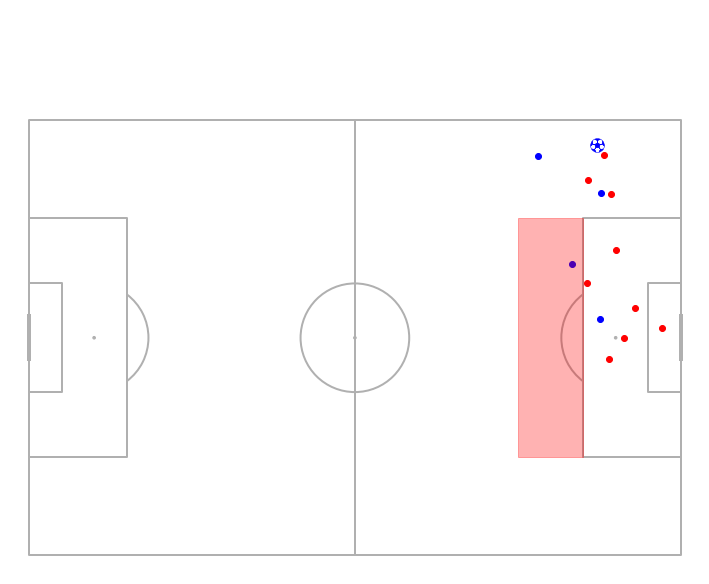

In [304]:
pitch = Pitch()

fig, axs = pitch.grid(figheight=8, endnote_height=0, axis=False, grid_height=0.83)

for player in list(cross.freeze_frame)[0]:
    if player['teammate']:
        pitch.scatter(player['location'][0], player['location'][1], c='blue',  ax=axs['pitch'])
    else:
        pitch.scatter(player['location'][0], player['location'][1], c='red',  ax=axs['pitch'])


# plot cross event 
pitch.scatter(list(cross.loc_x)[0], list(cross.loc_y)[0], marker='football', edgecolors= "blue",
                    s=200, ax=axs['pitch'], label='passer', zorder=1.2)


if 60 - list(cross.loc_y)[0] > 0:
    pitch.polygon([right_zone_coordinates[optimal_zone]], color=(1, 0, 0, 0.3), ax=axs['pitch'] )
else:
    pitch.polygon([left_zone_coordinates[optimal_zone]], color=(1, 0, 0, 0.3), ax=axs['pitch'] )


plt.show()